# HAMILTONIAN MONTE CARLO
> **Key conceptual reference**: ["MCMC METHOD 2: Hamiltonian Monte Carlo (HMC)" from "Markov chain Monte Carlo (MCMC)" from _Sampling Methods_ from **Bayesian Inference** from `conceptual-notes`](https://github.com/pranigopu/mastersProject/blob/main/conceptual-notes/bayesian-inference/sampling-methods/markov-chain-monte-carlo-mcmc/hamiltonian-monte-carlo-hmc.md)

---

**Topics discussed**:

1. [Introduction](#1.-Introduction)
2. [Conceptual and Practical Basics](#2.-Conceptual-and-Practical-Basics)
    - [Leapfrog integrator](#Leapfrog-integrator)
    - [HMC sampler](#HMC-sampler)
3. [Basic Application](#3.-Basic-Application)
4. [HMC for Parameters of a Linear Regression Model](#4.-HMC-for-Parameters-of-a-Linear-Regression-Model)

# 1. Introduction
HMC is a class of MCMC methods that uses gradients (of the log-probability of the posterior distribution) to generate new proposed states (i.e. new samples proposed to be from the target distribution). The gradients of the log-probability of the posterior evaluated at a given state (i.e. a given sample) gives information about the posterior density function's geometry.

_Why is the negative log-probability of the posterior used, rather than the posterior itself?_ The mathematical basis for it shall become clear in the subsection ["Mathematical formulation"](#mathematical-formulation). However, note that the negative log-probability preserves the distribution of the posterior's probability mass as well as the posterior's modes, except that the modes are represented by minima instead of maxima. Hence, samples from a high-probability-mass region of the negative log-probability of the posterior follow the same distribution as samples from a high-probability-mass region of the posterior itself.

HMC tries to avoid the random walk behavior typical of Metropolis-Hastings by using the gradient to propose new positions (i.e. new samples) that is both far from the current position (i.e. current sample) and with high acceptance probability. This allows HMC to better scale to higher dimensions and, in principle, to more complex geometries (compared to alternative methods). Intuitively, we can think of HMC as a Metropolis-Hasting algorithm with a better sample proposal distribution.

---

**NOTE 1**: The benefit of consistently proposing new positions that are both far from the current position and with high acceptance rate is that you are likely to gain a much more representative and thus accurate sample of the distribution you want to estimate, but using fewer sampled values; in other words, it tends to make sampling more efficient.

**NOTE 2**: Remember that a "sample" here is a tuple of one or more values proposed parameter values of the target distribution. What we are trying to do, here and in all sampling methods, is discover (with some level of uncertainty) how well the various potential parameter values would describe the target distribution. Note also that a "position" or a "state" is simply a sample, i.e. simply a proposed tuple of parameter values.

**NOTE 3**: Sampling from the negative log-probability of the posterior is the same in effect as sampling from the posterior itself (i.e. both lead to samples following the same distribution). Hence, when I refer to sampling from the posterior in the context of HMC, note that I am referring more precisely to sampling from the negative log-probability of the posterior. The distinction is only needed to describe the specific process of HMC and does not reflect on the actual samples obtained. However, apart from describing the specific process of HMC, I find that speaking in terms of sampling from the posterior makes it easier to relate the conceptual basis of HMC (i.e. Hamiltonian mechanics) to posterior sampling, which is why, when possible, I prefer to speak of sampling from the posterior rather than sampling from the negative log-probability of the posterior.

---

As we shall see, HMC is inspired from Hamiltonian mechanics and is hence often explained with an analogy to classical mechanics. In the context of HMC context, the "position" of the sample can be thought of as the location of a particle, and the "momentum" provides the force needed to move the particle through the parameter space.

# 2. Conceptual and Practical Basics

## Relevance of the implementations
The implementations of the leapfrog integrator and the HMC function will be presented mostly for conceptual clarity about HMC in practice. However, for my practical purposes beyond conceptual understanding, I shall use an implementation packaged in the `tensorflow_probability` module, rather than a custom HMC function, due to the vastly greater convenience it offers. See its documentation here: [`tfp.mcmc.HamiltonianMonteCarlo` (Tensorflow documentation)](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/HamiltonianMonteCarlo).

## Leapfrog integrator
> **References**:
>
> - [_Deriving the Leapfrog Integrator_ from **rnowling.github.io/math**](https://rnowling.github.io/math/2016/11/11/deriving-leapfrog.html)
> - [_Leapfrog integrator_ from **johndcook.com/blog**](https://www.johndcook.com/blog/2020/07/13/leapfrog-integrator/)

Leapfrog integration is a method for numerically integrating differential equations of the form $\frac{d^2x}{dt^2} = f(x)$, i.e. $x'' = f(x)$ (reference: [_Leapfrog integration_ from **Wikipedia**](https://en.wikipedia.org/wiki/Leapfrog_integration)). Here, $x$ is a function of $t$. In general, integrating a differential equation means solving it, i.e. finding the functions for the differentials so as to satisfy the differential equation. In the case of leapfrog integration, integrating a differential equation of the form $x'' = f(x)$ means solving for the function $x$ (note that $f$ is given). More precisely, for discrete steps along $t$, the leapfrom integrator tries to approximate the values for $x$ across for a given number of steps. Typically, $x$ is position and $t$ is time; this analogy can be extended to any use case.

### Mathematical basis
The leapfrog integrator is a numerical method for solving differential equations of the form:

$x'' = f(x)$

Here, note the following:

- $x$ is a function of $t$
- Typically, $x$ is position and $t$ is time
- We are dealing with a $k$ dimensional space, $k \geq 1$
- Hence, if $x(t)$ is the position, it would be an array of coordinates

---

We use the leapfrog integrator when there is no analytical equation for $x(t)$ that satisfies the differential equation, or at least when the analytical equation is too complex to derive. The idea is to use a numerical integration algorithm to compute values of $x(t)$ on discrete time steps $\Delta t$. In the following equations, we can see how the values are approximated for $x$. Note that here, we are using the analogy (which can be accurately translated to posterior sampling) of $x$ as position, $v$ as velocity, $a$ as acceleration and $t$ as time. For the full derivation, see: [_Deriving the Leapfrog Integrator_ from **rnowling.github.io/math**](https://rnowling.github.io/math/2016/11/11/deriving-leapfrog.html); note that I have altered the notation according to [_Leapfrog integrator_ from **johndcook.com/blog**](https://www.johndcook.com/blog/2020/07/13/leapfrog-integrator/):

- $a(t) = − f(x(t))$ (calculating $a$ for the current time step)
- $x(t + \Delta t) = x(t) + v(t)\Delta t + \frac{1}{2}a(t)\Delta t^2$ (calculating $x$ for the next time step)
- $a(t + \Delta t) = − f(x(t+\Delta t))$ (calculating $a$ for the next time step)
- $v(t + \Delta t)=v(t) + \frac{1}{2}(a(t) + a(t + \Delta t))\Delta t$ (calculating $v$ for the next time step)

---

**SIDE NOTE**:

$x$, $v$ and $a$ have the following relationships:

- $x''(t) = a(t) = f(x)$
- $v''(t) = a'(t)$
- $x''(t) = v'(t) = a(t)$
- $x'(t) = v(t)$

The above relationships can be easily understood if you consider:

- $x$ as position
- $v$ as velocity
- $a$ as acceleration
- $t$ as time

_Note that position, velocity and acceleration are all represented by vectors, if spatial dimensions $\geq 1$._

### Basic demonstration
> **Reference**: [_Leapfrog integrator_ from **johndcook.com/blog**](https://www.johndcook.com/blog/2020/07/13/leapfrog-integrator/).

In the following demontration, using leapfrog integrator, we shall solve:

$x'' = f(x)$

In this case, we can find the exact solution mathematically as:

$x(t) = \sin(t)$

This helps us test leapfrog integration, even though this is not a typical use case.

---

**TIP**: _In the code below, alter the time step_ `Δt` _to see how the estimation accuracy changes._

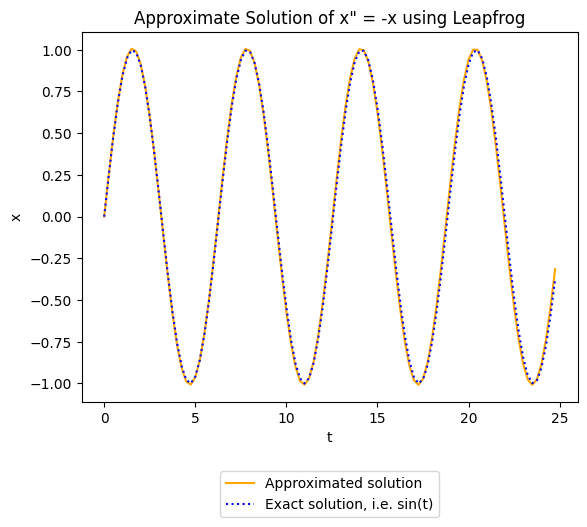

In [2]:
# NECESSARY IMPORTS

import numpy as np
import matplotlib.pyplot as plt

#================================================
# DEFINING f IN x" = f(x):

f = lambda x: -x

#================================================
# DEFINING THE INTEGRATOR'S PARAMETERS

n_steps = 100         # Number of approximation steps
Δt = 0.25             # Step size
x = np.empty(n_steps) # Position (i.e. the coordinates of the position)
v = np.empty(n_steps) # Velocity (i.e. the velocity vector)

#================================================
# INITIAL CONDITIONS

x[0] = 0
v[0] = 1
a_new = f(x[0])

#================================================
# PERFORMING LEAPFROG INTEGRATION

for i in range(1, n_steps): # Start with index 1 because index 0 contains the initial values
    a_old = a_new
    x[i] = x[i-1] + v[i-1]*Δt + 0.5*a_old*Δt**2
    a_new = f(x[i])
    v[i] = v[i-1] + 0.5*(a_old + a_new)*Δt

#================================================
# PLOTTING THE RESULTS

# NOTE: x is calculated for discrete points of time t as per time steps Δt

t = np.arange(0, len(x)*Δt, Δt)
plt.plot(t, x, label='Approximated solution', color='orange')
plt.plot(t, np.sin(t), linestyle='dotted', label='Exact solution, i.e. sin(t)', color='blue')
plt.title('Approximate Solution of x\" = -x using Leapfrog')
plt.xlabel('t')
plt.ylabel('x')
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.25))
plt.show()

### Leapfrog integration for HMC
Here, the leapfrom method shall be used to solve Hamiltonian equations.

---

To obtain the Hamiltonian equations, let us start with the Hamiltonian function (or simply the "Hamiltonian"):

$H(\theta, m) = K(m) + V(\theta) =$ _constant_

Here:

- We are dealing with a $k$ dimensional space (e.g. the sample space of a models' parameters)
- $\theta$: Position in the $k$ dimensional space; $\theta = (\theta_1, \theta_2 ... \theta_k)$, where $\theta_i$ is the $i$-th dimensional coordinate
- $m$: Momentum generalised for $k$ dimensions; $m = (m_1, m_2 ... m_k)$, where $m_i$ is the momentum along the $i$-th axis
- $K(m)$: System's total kinetic energy (independent of the position $\theta$)
- $V(\theta)$: System's total potential energy (independent of momentum $m$)

---

Using the Hamiltonian, we write Hamilton's equations of motion:

Equation 1:

$\frac{d \theta}{dt} = \frac{\delta H}{\delta m} = \frac{\delta K}{\delta m} + \frac{\delta V}{\delta m} = \frac{\delta K}{\delta m}$ (because $\frac{\delta V}{\delta m} = 0$)

i.e.

$\frac{d \theta}{dt} = \frac{\delta K}{\delta m}$

Equation 2:

$\frac{dm}{dt} = - \frac{\delta H}{\delta \theta} = - \frac{\delta K}{\delta \theta} - \frac{\delta V}{\delta \theta} = - \frac{\delta V}{\delta \theta}$ (because $\frac{\delta K}{\delta \theta} = 0$)

i.e.

$\frac{dm}{dt} = - \frac{\delta V}{\delta \theta}$

**NOTE**: _We are using a mechanistic analogy which can be accurately extended to posterior sampling._

---

We determine the change in the position $\theta$ according to the momentum $m$, and equation 2 shows that the momentum changes with respect to time by $- \frac{\delta V}{\delta \theta}$. Hence, starting with an initial momentum, the leapfrog integrator takes steps through time based on the chosen time step $\Delta t$, and for each step through time, it calculates the change in momentum since the last time step, thus obtaining the new momentum and the position for the next time step. In the context of HMC, each new position $\theta$ is a new sample from the posterior, and "time step" means a sampling step.

---

> **Reference for the above**: ["MCMC METHOD 2: Hamiltonian Monte Carlo (HMC)" from "Markov chain Monte Carlo (MCMC)" from _Sampling Methods_ from **Bayesian Inference** from `conceptual-notes`](https://github.com/pranigopu/mastersProject/blob/main/conceptual-notes/bayesian-inference/sampling-methods/markov-chain-monte-carlo-mcmc/hamiltonian-monte-carlo-hmc.md)

---

The implementation is below is modified from [_Hamiltonian Monte Carlo from scratch_ from **colindcarroll.com**](https://colindcarroll.com/2019/04/11/hamiltonian-monte-carlo-from-scratch/).

In [11]:
def leapfrog(θ, m, δVδθ, T, Δt):
    '''
    Leapfrog integrator for Hamiltonian Monte Carlo
    ------------------------------------
    Parameters
    
    θ    : Initial position (i.e. coordinates of the initial position)
    m    : Momentum (i.e. momentum vector)
    δVδθ : Callable that returns the gradient of the "potential energy" V
    T    : Quantity indicating how long to integrate for
    Δt   : Quantity indicating how long each integration step should be
    ------------------------------------
    NOTE: Why arrays for position and momentum? Because we are dealing with a k-dimensional space (k >= 1).
    ------------------------------------
    Returns

    θ, m : New position and momentum (both are vectors; θ is an array of coordinates, m is a vector)
    '''
    
    θ, m = np.copy(θ), np.copy(m)

    m -= Δt * δVδθ(θ)/2            # half step
    for _ in range(int(T/Δt) - 1):
        θ += Δt * m                # whole step
        m -= Δt * δVδθ(θ)          # whole step
    θ += Δt * m                    # whole step
    m -= Δt * δVδθ(θ)/2            # half step

    # Negate momentum at end of trajectory to make the proposal symmetric:
    '''
    REFERENCE FOR THE ABOVE COMMENT:
    MCMC using Hamiltonian dynamics by Radford M. Neal, https://arxiv.org/pdf/1206.1901
    '''
    return θ, -m

## HMC sampler

### Mathematical formulation
**PRELIMINARY POINT: The goal of using a sampling method**:

The whole point of a sampling method is to estimate an unknown distribution. Hence, in practice, when we sample from the posterior, it is because we do not know the posterior. However, due to certain theoretical guarantees in the general MCMC approach (mainly the guarantee that the steady-state transition probabilities of the sampler's Markov chain simulate the posterior distribution; see: ["Markov chain Monte Carlo (MCMC)" from this document](#markov-chain-monte-carlo-mcmc)), we have that after a certain number of samples, we begin to draw samples as if from the posterior. Hence, when we say "sample from the posterior", we mean that in the way described by the general MCMC approach. How HMC in implements the general MCMC approach is what we shall see now.

---

Let us first define the following:

- $P$, the measure of probability density or mass (depending on context)
- $\theta$, the position, i.e. the sample taken from the posterior
- $\Theta$, the sample space of positions
- $p$, the target distribution, i.e. the posterior distribution
- $m$, the momentum applied to the imaginary sampler point at position $\theta$

**NOTE**: $\theta$ _denotes a specific parametrisation of the generalised model which we are trying to fit to the data. Hence, since models are usually parameterised by more than one specific parameter,_ $\theta$ _is usually a vector of specific parameters._ $\Theta$ _denotes the hypothesis space, i.e. the set of all possible parametrisations considered by us of the generalised model. Hence, note that_ $\theta$ _represents a specific model, whereas_ $\Theta$ _represents the sample space of specific models, each being a specific parametrisation of the generalised model. Also note that if_ $\theta$ _is k-dimensional (i.e. has k elements, denoting k specific parameters), then_ $\Theta$ _is a k-dimensional sample space, and consequently, we are dealing with "positions" and "momentum" in a k-dimensional space._

---

**What do we need to find?**

- $p = P(\theta|D)$, the target distribution, i.e. the posterior distribution

**What do we have available?**

- $D$, dataset of observations (from the data-generation process we are trying to model)
- $P(D|\theta)$, the likelihood of dataset $D$ given the model parameterised by $\theta$
- $P(\theta)$, the prior distribution of $\theta$ defined before the inference
- $P(m)$, the distribution of momentum values chosen by us

**What do we know?**

- $\displaystyle P(\theta|D) = \frac{P(D|\theta) P(\theta)}{\int_{\theta' \in \Theta} P(\theta', D) d\theta'} \propto P(D|\theta) P(\theta)$
- $P(\theta, m) = P(\theta|D) P(m)$

**What we do not know in practice**:

- $\displaystyle \int_{\theta' \in \Theta} P(\theta', D) d\theta'$, the denominator or "evidence" in Bayesian inference

**NOTE**: _Of course, if we knew the denominator, the posterior_ $p = P(\theta|D)$ _would already by known._

---

Why bother with the joint distribution? Because of the following:

$P(\theta, m) = P(\theta|D) P(m)$

$\implies \log P(\theta, m) = \log (P(\theta|D) P(m)) = \log P(\theta|D) + \log P(m)$

$\implies - \log P(\theta, m) = - \log P(\theta|D) - \log P(m)$

The above equation is in the form of a Hamiltonian, where:

- $H(\theta, m) = - \log P(\theta, m)$
- $K(m) = - \log P(m)$ ("kinetic energy")
- $V(\theta) = - \log P(\theta|D)$ ("potential energy")

---

**NOTE**:

- Probabilities are always between 0 and 1
- Hence, the logarithms of probabilities are always less than or equal to 0
- Hence, negative logarithms of probabilities are always $\geq$ to 0
- Hence, the physical motion-based analogy is valid
- Hence means that Hamilton's equations of motion will work as intended

---

**REMINDER**:

Hamiltonian's equations are as follows:

Equation 1:

$\frac{d \theta}{dt} = \frac{\delta H}{\delta m} = \frac{\delta K}{\delta m} + \frac{\delta V}{\delta m} = \frac{\delta K}{\delta m}$ (because $\frac{\delta V}{\delta m} = 0$)

i.e.

$\frac{d \theta}{dt} = \frac{\delta K}{\delta m}$

Equation 2:

$\frac{dm}{dt} = - \frac{\delta H}{\delta \theta} = - \frac{\delta K}{\delta \theta} - \frac{\delta V}{\delta \theta} = - \frac{\delta V}{\delta \theta}$ (because $\frac{\delta K}{\delta \theta} = 0$)

i.e.

$\frac{dm}{dt} = - \frac{\delta V}{\delta \theta}$

---

We know that $\displaystyle P(\theta|D) = \frac{P(D|\theta) P(\theta)}{\int_{\theta' \in \Theta} P(\theta', D) d\theta'}$

$\implies \log P(\theta|D) = \log \frac{P(D|\theta) P(\theta)}{\int_{\theta' \in \Theta} P(\theta', D) d\theta'} = \log(P(D|\theta) P(\theta)) - \log(\int_{\theta' \in \Theta} P(\theta', D) d\theta')$

---

For convenience, put $z = \int_{\theta' \in \Theta} P(\theta', D) d\theta'$. Hence:

$V(\theta) = - \log P(\theta|D) = - \log(P(D|\theta) P(\theta)) + \log z$

---

But note that $z$ marginalises out the position $\theta$. Hence, $z$ is independent of position $\theta$.

$\implies \frac{\delta V}{\delta \theta} = \frac{\delta (- \log(P(D|\theta) P(\theta)))}{\delta \theta} + 0 = \frac{\delta (- \log(P(D|\theta) P(\theta)))}{\delta \theta}$

**NOTE**: $\frac{dm}{dt} = - \frac{\delta V}{\delta \theta} \implies \frac{\delta V}{\delta \theta}$ _determines momentum change across time steps (i.e. across sampling steps)._

---

**What do we need to find?**

- The target distribution, i.e. the posterior distribution $p = P(\theta|D)$

**What do we have available?**

- $K(m) = - \log P(m)$, since we already have $P(m)$
- $\frac{\delta \theta}{\delta t} = \frac{\delta K}{\delta m}$, since we already have $K(m)$
- $H = - \log P(\theta, m)$, since we already have $P(\theta, m)$
- $\frac{\delta m}{\delta t} = - \frac{\delta V}{\delta \theta}$

**What do we know?**

- How a body's momentum changes across time depends on how the potential energy acts on the body
- As an analogy for the above, imagine the potential energy $V$ as a set of gravitational wells
- Hence, after picking $m$, we change it based on $V$
- $V = - \log P(\theta|D)$ has the same density distribution as $p = P(\theta|D)$
- In other words, the way $V$ acts upon a body emulates the probability densities in $p$
- Hence, sampling a body's position across time based on $V$ is the same as sampling from $p$
- Hence, samples aggregated from $V$ can be used to estimate $p$

---

_How can we use what we know/have available to find what we need?_

Starting with a randomly sampled momentum value, we can use $\frac{\delta m}{\delta t} = - \frac{\delta V}{\delta \theta}$ to update the momentum across time steps and thereby travel along the contours of the negative log-probability of the posterior and sample the next positions in similarly high-probability-mass regions as the initial sample (i.e. initial position). Using these samples, we can estimate the target distribution $p$, i.e. the posterior. It is key to note that, as derived before, $\frac{\delta V}{\delta \theta} = \frac{\delta (- \log(P(D|\theta) P(\theta)))}{\delta \theta}$, which means the gradient used to update momentum across time steps only depends on what we already know, namely the likelihood $P(D|\theta)$ and the prior $P(\theta)$.

Note that we can make the proposal after a number of iterations for travelling along the above contour using the chosen momentum — chosen based on $P(m)$ — and if we do so, we can get the proposed sample from a similarly high-probability-mass region of the posterior that is also far from the initial sample. This number of iterations (or alternatively, the time for which we allow the algorithm to travel along the contour) can be picked at random to optimise the algorithm's performance in the long run (reference: [_Michael Betancourt: Scalable Bayesian Inference with Hamiltonian Monte Carlo_ from London Machine Learning Meetup, **YouTube**](https://www.youtube.com/watch?v=jUSZboSq1zg)).

---

_Hence, we see how HMC allows more efficient exploration of the high-probability-mass region of the posterior, compared to the approaches that explore by diffusing from a starting point over time (e.g. Metropolis-Hastings)._

### Algorithm and practical computation
- Initialise current sample as $\theta_0$
- Sample $m$ from $\text{Normal}(0, \sigma I)$
- Simulate $\theta_i$ and $m_i$ for some amount of time $T$
- Take $\theta_T$ as our new proposed sample
- Use the Metropolis acceptance criterion to accept or reject $\theta_T$

_Why we still need to use the Metropolis acceptance criterion?_ Intuitively, because we can think of HMC as a Metropolis-Hasting algorithm with a better proposal method. But a further numerical justification is that the accept-reject steps help correct for errors introduced by the numerical simulation of the Hamiltonian equations.

> **Reference**: ["11.9.3. Hamiltonian Monte Carlo" from "11.9. Inference Methods" from _11. Appendiceal Topics_ from **Bayesian Computation Notebook**](https://bayesiancomputationbook.com/markdown/chp_11.html#hamiltonian-monte-carlo)

---

The above algorithm is essentially two key steps (done for each iteration of HMC):

**Step 1: Obtain a new momentum**:

- A new momentum is randomly drawn from a Gaussian distribution
- The momentum is drawn independently of the current momentum and position

**NOTE**: _The momentum is always drawn anew from a Gaussian distribution every iteration._

 **Step 2: Probabilistically update both position and momentum**:
 
 - New momentum and position are obtained after a number of simulation steps
 - The new position is the new proposed sample
 - Update is "probabilistic" due to the Metropolis acceptance criterion

**NOTE**: _The new momentum and the new position are used to calculate the new Hamiltonian. This is important, because the difference between the previous Hamiltonian and the new Hamiltonian is needed to obtain the acceptance probability when checking the Metropolis acceptance criterion, as we shall see later._

> **Reference**: [_MCMC using Hamiltonian dynamics_ by Radford M. Neal](https://arxiv.org/pdf/1206.1901)

---

**NOTE**: "Simulate" <br>
$\implies$ Simulate the system defined by the Hamiltonian equations <br>
$\implies$ Travelling along the contours as per the momentum

#### Metropolis acceptance criterion for HMC
> **Reference**: [_MCMC using Hamiltonian dynamics_ by Radford M. Neal](https://arxiv.org/pdf/1206.1901)

As stated before, we need to use the Metropolis acceptance criterion for two reasons: (1) intuitively, we can think of HMC as a Metropolis-Hasting algorithm with a better proposal method, and (2) as a further numerical justification, the accept-reject steps help correct for errors introduced by the numerical simulation of the Hamiltonian equations.

_But how do we define the Metropolis criterion for HMC?_

Note that in the second essential step of the HMC algorithm, Hamiltonian dynamics are used to propose a new position (i.e. a new sample/state). Starting with the current position and momentum $(\theta, m)$, Hamiltonian dynamics are simulated for a number of steps (e.g. using the Leapfrog method); to be exact, we simulate the trajectory of the point representing the sampler for a number of steps, based on the momenta (as calculated throughout the steps) and the contours of the posterior (or more precisely, the negative log-probability of the posterior). The momentum at the end of this simulated trajectory is then negated (to see why, see the note below), giving a new position and momentum $(\theta^∗, m^*)$. The new, i.e. proposed position $\theta^*$ is accepted as the next state of the Markov chain with probability:

$\min [1, e^{H(\theta, m)−H(\theta^∗, m^∗)}]$, where:

- $H$ is the Hamiltonian, given by $H(\theta, m) = K(m) + V(\theta)$
- $V$ is analogous to the potential energy in classical mechanics
- $K$ is analogous to the kinetic energy in classical mechanics

If the proposed state (i.e. position) is not accepted, the next state is the same as the current state.

---

**Intuition for the above**:

We have the following cases:

1. $e^{H(\theta, m)−H(\theta^∗, m^∗)} \geq 1 \implies H(\theta^∗, m^∗) \geq H(\theta, m)$
2. $e^{H(\theta, m)−H(\theta^∗, m^∗)} \leq 1 \implies H(\theta^∗, m^∗) \leq H(\theta, m)$

$H(\theta^∗, m^∗) \geq H(\theta, m)$ means the proposed state is from an equal or higher-probability-mass region of the posterior, which means it should always be accepted, because we want to sample more from equal or higher-probability-mass regions. $H(\theta^∗, m^∗) < H(\theta, m)$ means the proposed state is from a lower-probability-mass region, which means it should be accepted only probabilistically, with the probability of accepting it being proportional to its closeness to the current state (in terms of probability density), because we want there to be a lower but non-zero chance of sampling from a sparser region region after sampling from a denser region, with the condition that the lower the density, the lower the chance.

---

**NOTE: How do we calculate**  $H(\theta, m) − H(\theta^∗, m^∗)$ **?**

In the case of HMC, the Hamiltonian is given by:

$H(\theta, m) = - \log P(\theta, m) = - \log P(\theta|D) - \log P(m)$

Of course, we do not know $P(\theta|D)$, since this is the target distribution we want to find. However:

$P(\theta|D) \propto P(D|\theta) P(\theta)$

$\implies - \log P(\theta|D) \propto - \log(P(D|\theta) P(\theta)) = - \log P(D|\theta) - \log P(\theta)$

$\implies H(\theta, m) \propto - \log P(D|\theta) - \log P(\theta) - \log P(m)$

Likewise, $H(\theta^*, m^*) \propto - \log P(D|\theta^*) - \log P(\theta^*) - \log P(m^*)$

The right-hand side in the above two statements is sufficient for our needs. Why? Consider:

Let $P(\theta|D) = \frac{P(D|\theta) P(\theta)}{z}$ for some normalisation constant $z$

$\implies - \log P(\theta|D) = - \log \frac{P(D|\theta) P(\theta)}{z} = - \log P(D|\theta) - \log P(\theta) + \log z$

$\implies H(\theta, m) = - \log P(D|\theta) - \log P(\theta) - \log P(m) + \log z$

Likewise, $H(\theta^*, m^*) = - \log P(D|\theta^*) - \log P(\theta^*) - \log P(m^*) + \log z$

Hence, we get $H(\theta, m) − H(\theta^∗, m^∗)$ as follows:

$- \log P(D|\theta) - \log P(\theta) - \log P(m) + \log z - (- \log P(D|\theta^*) - \log P(\theta^*) - \log P(m^*) + \log z)$

$= - \log P(D|\theta) - \log P(\theta) - \log P(m) + \log z + \log P(D|\theta^*) + \log P(\theta^*) + \log P(m^*) - \log z$

$= - \log P(D|\theta) - \log P(\theta) - \log P(m) + \log P(D|\theta^*) + \log P(\theta^*) + \log P(m^*)$

As we can see, the normalisation constant is eliminated, so it has no effect on the acceptance probability.

---

**NOTE: Why negate the momentum variable after the simulation?**

The negation of the momentum at the end of the simulated trajectory makes the Metropolis proposal symmetrical, as needed for the acceptance probability above to be valid (**NOTE**: _I do not get this point_). However, this negation need not be done in practice, since $K(m) = K(−m)$, and since the momentum is always replaced (by randomly sampling it from a Gaussian) in the first step of the next iteration.

### Implementation
> **References**:
>
> - [_Hamiltonian Monte Carlo from scratch_ from **colindcarroll.com**](https://colindcarroll.com/2019/04/11/hamiltonian-monte-carlo-from-scratch/)
> - [_MCMC using Hamiltonian dynamics_ by Radford M. Neal](https://arxiv.org/pdf/1206.1901)

In [12]:
from autograd import grad
import autograd.numpy as np
import scipy.stats as st

def hamiltonian_monte_carlo(n_samples, negative_log_prob, initial_position, T=1, Δt=0.5):
    '''
    Run Hamiltonian Monte Carlo sampling.
    ------------------------------------
    Parameters
    
    n_samples         : Number of samples to return
    negative_log_prob : Callable that returns the negative log probability to sample from
    initial_position  : The initial position to start sampling from
    T                 : Quantity indicating how long to integrate; smaller is faster and more correlated
    Δt                : Quantity indicating how long each integration step should be; smaller is slower and more accurate.
    ------------------------------------
    Returns

    Array of length `n_samples`
    '''
    
    # Using autograd to obtain the required differential:
    δVδθ = grad(negative_log_prob)

    # Collect all our samples in a list:
    samples = [initial_position]

    # Keep a single object for momentum resampling:
    momentum = st.norm(0, 1) # Keeping σ (sigma) at 1
    size = n_samples*initial_position.shape[0]
    momentum_samples = momentum.rvs(size=size)
    '''
    EXPLAINING THE ABOVE THREE LINES:
    
    Let's say the `initial_position` is a 10-dimensional vector and `n_samples` is 100.
    Then, we want 100 x 10 momentum draws (note that this is just an example).
    To achieve such functionality, we do one call to `momentum.rvs` and iterate over rows.
    '''
    
    for m in momentum_samples:
        # Integrate over our path to get a new position and momentum:
        θ_T, m_T = leapfrog(samples[-1], m, δVδθ, T=T, Δt=Δt)
        # NOTE: `θ_T` is the proposed position, i.e. proposed sample

        # Check Metropolis acceptance criterion:
        H_old = negative_log_prob(samples[-1]) - np.sum(momentum.logpdf(m))
        H_new = negative_log_prob(θ_T) - np.sum(momentum.logpdf(m_T))
        # NOTE: H denotes "Hamiltonian"
        if np.log(np.random.rand()) < H_old - H_new:
            '''
            EXPLAINING THE ABOVE CONDITION: See the implementation note below.
            '''
            samples.append(θ_T)
        else:
            samples.append(np.copy(samples[-1]))

    return np.array(samples[1:])

**IMPLEMENTATION NOTE: Explaining** `if np.log(np.random.rand()) < H_old - H_new`:

Note that the Metropolis acceptance probability for HMC is:

$min[1, e^{H(\theta, m) − H(\theta^∗, m^∗)}]$, where:

- $\theta$: Current position
- $m$: Current momentum
- $\theta^*$: Proposed position (after leapfrog integration steps)
- $m^*$: New momentum (after leapfrog integration steps)
- $H(\theta, m)$: `H_old`
- $H(\theta^*, m^*)$ = `H_new`

But note that:

$\min[1, e^{H(\theta, m) − H(\theta^*, m^*)}]$

$= \min[\log(1), \log(e^{H(\theta, m) − H(\theta^*, m^*)})]$

$= \min[0, H(\theta, m) − H(\theta^*, m^*)]$

Hence, we see that the condition `if np.log(np.random.rand()) < H_old - H_new` is equivalent to the condition `if np.random.rand() < np.exp(H_old - H_new)`, and both conditions accurately model the acceptance probability $\min[1, e^{H(\theta, m) − H(\theta^∗, m^∗)}]$.

# 3. Basic Application
> **Reference**: [`tfp.mcmc.HamiltonianMonteCarlo` (Tensorflow documentation)](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/HamiltonianMonteCarlo)

## Problem statement
We shall aim to estimate the following posterior distribution (given as a probability density function here):

$P(\theta|D) = \frac{1}{2}e^{-\theta(1+\theta)}$, where:

- $D$ is the data that conditions the probability of a certain model (i.e. a certain parametrisation) being accurate
- $\theta$ represents a certain parametrisation (i.e. a certain model) under the generalised model used

## Approach
As seen before, for HMC, we only need to know the unnormalised posterior, which consists of the following:

- $P(D|\theta)$, the likelihood (i.e. the likelihood of $D$ being generated by a certain parametrisation $\theta$ of the model)
- $P(\theta)$, the prior probability distribution of $\theta$ (assumed or approximated prior to observing the data $D$)

---

The above are used to obtain the unnormalised posterior $P(D|\theta) P(\theta)$, where $P(\theta|D) \propto P(D|\theta) P(\theta)$. However, as we have seen, HMC deals specifically with the negative log-probability of the posterior, which is proportional to the negative log-probability of the unnormalised posterior, which is all we need for HMC. In the particular `tensorflow_probability` implementation we are using, we need to pass the target log-probability as an argument (the unnormalised posterior, in our case), so we must pass the actual log-probability of the unnormalised posterior (not the negative of it).

## Necessary imports

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

## Defining the target log-probability
In the particular `tensorflow_probability` implementation we are using, we need to pass the target log-probability as an argument (the unnormalised posterior, in our case), so we must define $\log (P(D|\theta) P(\theta))$. For this example, we shall omit the definition of the likelihood and prior, and go straight to the expression proportional to the posterior distribution (i.e. our target distribution). In practice, however, this expression would be obtained using well-defined likelihood and prior functions.

In [3]:
# Target distribution is proportional to: `exp(-x (1 + x))`:
def unnormalized_log_prob(θ):
    return -θ*(1 + θ)

## Setting up the HMC sampler

In [4]:
# Defining key hyperparameters:
num_results = int(10e3) # Number of samples to be taken
num_burnin_steps = int(1e3) # Number of Markov chain steps (i.e. samples) to consider as "burn-in"

# Defining an simple step size adaptation transition kernel (explained in the notes below):
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    # The HMC transition kernel is wrapped within the simple step size adaptation transition kernel:
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_log_prob,
        num_leapfrog_steps=3,
        step_size=1.),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

**CONCEPTUAL NOTE: Transition kernel (a.k.a. Markov kernel)**:

A transition kernel in this context refers to a Markov kernel and pertains to a given Markov chain (note that "Markov chain" = "Markov process"). A transition kernel of a Markov chain is a function that defines the transitions of the Markov chain. Specificallly, it defines the transition probabilities between states in the Markov chain (as a side note, it is a generalisation of the transition matrix in finite state Markov chains).

> **Reference**: [_Markov kernel_, **Wikipedia**](https://en.wikipedia.org/wiki/Markov_kernel)

---

**TECHNICAL NOTE: `tensorflow_probability.mcmc.TransitionKernel`**:

The base class for all MCMC transition kernels (defined above). This class defines the minimal requirements to efficiently implement a Markov chain Monte Carlo (MCMC) transition kernel. A transition kernel returns a new state given some old state (as a side note, it also takes and returns additional information which may be used for (a) debugging or (b) optimisation purposes, i.e, to "recycle" previously computed results).

> **Reference**: [`tfp.mcmc.TransitionKernel` (Tensorflow documentation)](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/TransitionKernel)

---

**IMPLEMENTATION NOTE: `tensorflow_probability.mcmc.SimpleStepSizeAdaptation`**:

It is a subclass of `tensorflow_probability.mcmc.TransitionKernel` that uses a simple policy to adapt the inner kernel's `step_size`, i.e. the size of each transition step from the current state to a proposal state), based on `log_accept_prob`, i.e. the logarithm of the Metropolis acceptance probability (note that logarithms are used since they are more numerically conservative and hence help avoid arithmetic overflow). More precisely, it multiplicatively increases or decreases the `step_size` of the inner kernel based on the value of `log_accept_prob`.

> **Reference**: [`tfp.mcmc.SimpleStepSizeAdaptation` (Tensorflow documentation)](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/SimpleStepSizeAdaptation)

---

**TECHNICAL NOTE: `tfp.mcmc.HamiltonianMonteCarlo`**:

`tfp.mcmc.HamiltonianMonteCarlo` is a subclass of `tensorflow_probability.mcmc.TransitionKernel`, just as HMC is a subclass of MCMC.

## Running the HMC sampler

Defining the sampling function...

In [5]:
# Run the chain (with burn-in).
@tf.function # This decorator is explained in the notes below
def run_chain():
    # Run the chain (with burn-in).
    samples, is_accepted = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=1.,
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

    # Calculating summary statistics of the samples for quick and easy reporting and usage:
    sample_mean = tf.reduce_mean(samples)
    sample_stddev = tf.math.reduce_std(samples)
    is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))

    # Returning the summary statistics of the samples as well as the samples themselves:
    return samples, sample_mean, sample_stddev, is_accepted

**IMPLEMENTATION NOTE: `@tf.function` decorator**:

A tf.function that you define (for example by applying the @tf.function decorator) is just like a core TensorFlow operation: You can execute it eagerly; you can compute gradients; and so on.

> **Reference**: [Better performance with `tf.function` (Tensorflow documentation)](https://www.tensorflow.org/guide/function)

---

Running the sampling process by calling `run_chain`...

In [6]:
samples, sample_mean, sample_stddev, is_accepted = run_chain()

## Presenting the results
**Key points to keep in mind before interpreting the results**:

- In our example, we know our true posterior distribution already, so sampling was done only for demonstration.
- In practice, we do not have a true posterior distribution to compare with our sampled (i.e. estimated) posterior.
- MCMC sampling estimates the true posterior, i.e. the unnormalised posterior multiplied by the right normalisation constant. <br> **NOTE**: _The right normalisation constant is one that would turn the unnormalised posterior into a true probability measure._

SAMPLING SUMMARY
Mean: -0.5265
Standard Deviation: 0.7021
Acceptance Rate: 0.6351



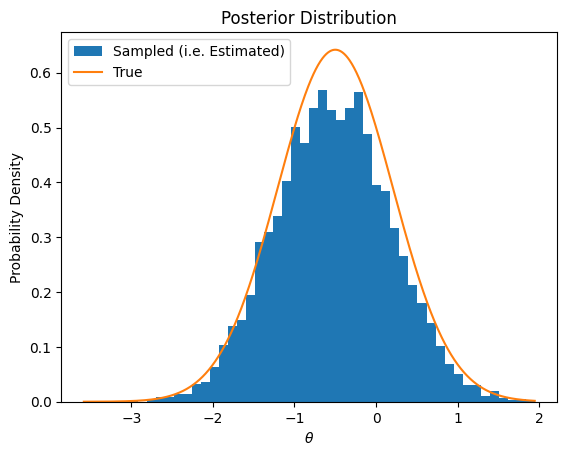

In [47]:
# Printing the summary statistics of the samples obtained:
print('SAMPLING SUMMARY')
print('Mean: {:.4f}\nStandard Deviation: {:.4f}\nAcceptance Rate: {:.4f}\n'.format(sample_mean.numpy(), sample_stddev.numpy(), is_accepted.numpy()))

#------------------------------------
# Plotting the sampled (i.e. estimated) and true posterior distributions:
plt.hist(samples, bins=50, label='Sampled (i.e. Estimated)', density=True)
t = np.linspace(min(samples), max(samples), 1000)
plt.plot(t, (1/2)*np.exp(-t*(1+t)), label='True')
plt.title('Posterior Distribution')
plt.xlabel('$\\theta$')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

# 4. HMC for Parameters of a Linear Regression Model

## Problem statement
Here, we are dealing with a problem of the following form:

- Vector of input values $x$ (each element belonging to a particular independent variable)
- Target value $y$ (belonging to a dependent variable defined in terms of $x$)
- A linear function $f$ defined on $x$ with weights and biases stored in parameter vector $\theta$, such that $y \approx f(x, \theta)$
- An random error term to account for the fact that $f(x, \theta)$ only approximates $y$

**NOTE**: $x = (x_1, x_2 ... x_k)$, _where each of_ $x_1, x_2 ... x_k$ _is a value of a particular [covariate](https://www.statology.org/covariate/)._

---

Hence, we have that:

$y = f(x, \theta) + \epsilon$

---

Since $f$ here is defined as a linear function, we have that:

$y = wx^T + b + \epsilon = w_1 x_1 + w_2 x_2 + ... w_k x_k + b + \epsilon$, where:

- $w$ is the row vector of weights, i.e. $w = (w_1, w_2 ... w_k)$
- $x$ is the row vector of inputs, i.e. $x = (x_1, x_2 ... x_k)$
- $y$ is the output, i.e. the target variable's value
- $b$ is the bias term (a single value)
- Hence, the parameter vector is given by $\theta = (w_1, w_2 ... w_k, b)$

---

Our goal is to estimate the posterior distribution of $\theta = (w_1, w_2 ... w_k, b)$ using HMC sampling.

## Necessary imports and setup

In [5]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

# To enable quick execution:
tf.compat.v1.enable_eager_execution()
# NOTE: Eager execution is the default in `tensorflow`

# To handle statistical distributions:
tfd = tfp.distributions

## Generating synthetic regression data
For this demonstration, we shall be using synthetic regression data. Note the following:

- The data is generated using a linear model $f(x, \theta)$
- There are `dims` independent variables, i.e. $x = (x_1, x_2 ... x_{\text{dims}})$
- Hence, we also have that the weights vector $w = (w_1, w_2 ... w_{\text{dims}})$
- There is no bias term; hence, $\theta = w$

---

Furthermore, we have the following:

**1. The true distribution of weights**

$w \sim \text{MultivariateNormal}(\mu, \sigma I)$, where:

- $\mu \in \mathbb{R}^{\text{dims}}$ is the vector of the means of each weight
- $\sigma \in \mathbb{R}$ is the true scale of the weights' distribution
- $I$ is the identity matrix

**2. The true distribution of the noise term**

$\epsilon \sim \text{Normal}(0, 1)$

---

More precisely, we put the following:

- $\text{dims} = 10$, i.e. there are 10 independent variables
- $\mu = (0, 0 ... 0)$, i.e. the mean of each weight is 0
- $\sigma = 0.3$

In [6]:
# Settings for the synthetic data:
num_samples = 500
dims = 10
true_sigma = 0.3 # True scale of the weights' distribution; unknown and inaccessible to the HMC sampler

x = np.random.rand(dims, num_samples) # Randomly drawing independent variable values
w = true_sigma*np.random.randn(1, dims) # => w ~ MultivariateNormal(0, σI); this is unknown and inaccessible to the HMC sampler
ε = np.random.randn(num_samples) # => ε ~ Normal(0, 1); this is known and accessible by the likelihood function
y = w.dot(x) + ε

# Squeezing `w` and `y`to remove excess dimensions:
w = w.squeeze()
y = y.squeeze()

Note that in practice, `true_sigma` should be unknown the the HMC sampler, since the true distribution of the weights is exactly what HMC aims to find, which means HMC presupposes that the true distribution of the weights is unknown. Of course, we are dealing with a demonstration that uses synthetic data, so for demonstrative purposes, we do in fact know the distribution of the weights. But in practice, of course, we expect this to be unknown to us to begin with.

---

Some visualisation...

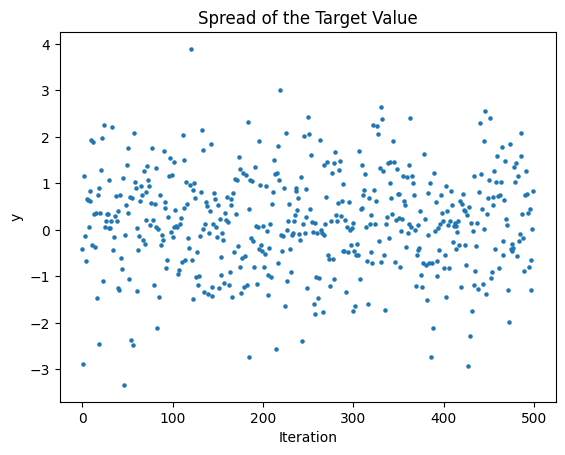

In [7]:
plt.scatter(range(len(y)), y, s=5)
plt.title('Spread of the Target Value')
plt.xlabel('Iteration')
plt.ylabel('y')
plt.show()

## Defining the prior and likelihood
**Prior**:

We define the prior as $P(\theta) = \text{MultivariateNormal}(0, I)$, where $I$ is the identity matrix.

---

**Likelihood**:

What about the likelihood? We can show that, given $\epsilon \sim \text{Normal}(0, 1)$, $y$ is distributed as follows:

$y \sim \text{Normal}(wx^T, 1)$, where:

- $w$ is the row vector of weights, i.e. $w = (w_1, w_2 ... w_k)$
- $x$ is the row vector of inputs, i.e. $x = (x_1, x_2 ... x_k)$
- $y$ is the output, i.e. the target variable's value

Hence, the likelihood _density_ of getting $y$ given input $x$ and parameterisation $\theta$ is given by $\text{Normal}(wx^T, 1)(y)$.

**NOTE**: _We can only use density, because_ $y$ _is distributed across a continuous range, which means point-wise probability mass is always 0._

---

Function definitions...

In [17]:
def make_weights_prior(dims, log_sigma):
    return tfd.MultivariateNormalDiag(loc=tf.zeros([dims]), scale_diag=tf.math.exp(log_sigma)*tf.ones([dims]))

def make_response_likelihood(w, x):
    if w.shape.ndims == 1:
        y_bar = tf.matmul(w[tf.newaxis], x)[0]
    else:
        y_bar = tf.matmul(w, x)
    return tfd.Normal(loc=y_bar, scale=tf.ones_like(y_bar))

**NOTE**: _The above functions return a distribution object and not a probability or log-probability value._

## Setting up the HMC sampler

In [18]:
# Setup assumptions:
dtype = np.float32
num_samples = 500
dims = 10
tf.random.set_seed(10014)
np.random.seed(10014)

# The variable to optimise:
log_sigma = tf.Variable(0., dtype=dtype, name='log_sigma')
# Why "log"? See the note below.

# Optimiser:
optimizer = tf.optimizers.SGD(learning_rate=0.01)

**IMPLEMENTATION NOTE: Why use `log_sigma`?**

We want the posterior distribution of the weights $w$. Now, observe that $\sigma$ (sigma) is the scale of weights' distribution, and is the only parameter of the weights' distribution that is yet unknown (we assume that the mean is given as zero; see the side note below). Hence, optimising $\sigma$ is the key to accurately estimating the posterior distribution of $w$. Now, note that optimising $\sigma$ is equivalent to optimising $\log \sigma$, and since logarithms are more numerically conservative (thus helping avoid arithmetical overflow), we shall optimise $\log \sigma$, denotes by the identifier `log_sigma`.

**SIDE NOTE**: _As a side note, we take for granted that the mean of the weights is zero, but if we did not take it for granted, we would have to optimise the mean as well; but we take it for granted to make our task easier for the purpose of demonstration._

---

Defining the sampling function...

In [19]:
@tf.function
def mcem_iter(weights_chain_start, step_size): # MCEM = Monte Carlo Expectation Maximisation
    with tf.GradientTape() as tape:
        tape.watch(log_sigma)
        prior = make_weights_prior(dims, log_sigma)

        # Necessary function to pass as an argument to the HMC kernel:
        def unnormalized_posterior_log_prob(w):
            likelihood = make_response_likelihood(w, x)
            return (prior.log_prob(w) + tf.reduce_sum(likelihood.log_prob(y), axis=-1))

        # Function to keep track of the sampling process, for reporting purposes:
        def trace_fn(_, pkr):
            return (pkr.inner_results.log_accept_ratio,
                  pkr.inner_results.accepted_results.target_log_prob,
                  pkr.inner_results.accepted_results.step_size)

        # Sampling a few times using HMC to estimate a target log-probability for optimising `log_sigma`:
        num_results = 2 # Number of samples we want to draw using HMC before optimising `log_sigma` and retrying
        weights, (log_accept_ratio, target_log_prob, step_size) = tfp.mcmc.sample_chain(
            num_results=num_results,
            num_burnin_steps=0,
            current_state=weights_chain_start,
            kernel=tfp.mcmc.SimpleStepSizeAdaptation(
                tfp.mcmc.HamiltonianMonteCarlo(
                    target_log_prob_fn=unnormalized_posterior_log_prob,
                    num_leapfrog_steps=2,
                    step_size=step_size,
                    state_gradients_are_stopped=True),
                # Adapt for the entirety of the trajectory:
                num_adaptation_steps=2),
            trace_fn=trace_fn,
            seed=123)
        
        # We do an optimization step to propagate `log_sigma` after two HMC steps to propagate `weights`:
        loss = -tf.reduce_mean(target_log_prob)
        
    avg_acceptance_ratio = tf.math.exp(tfp.math.reduce_logmeanexp(tf.minimum(log_accept_ratio, 0.)))
    optimizer.apply_gradients([[tape.gradient(loss, log_sigma), log_sigma]])
    weights_prior_estimated_scale = tf.math.exp(log_sigma)
    return (weights_prior_estimated_scale, weights[-1], loss, step_size[-1], avg_acceptance_ratio)

**Explaining the above**:

Notice that unlike the previous use-case, where we obtained the sampled (i.e. estimated) posterior distribution of a model parameter, in this case, in every call of `mcem_iter`, we are resetting the prior based on $\log \sigma$ only running HMC to get two samples before optimising the parameter $\log \sigma$ for the next call of `mcem_iter`. Our aim here is not to get a sampled posterior distribution of the weights, but rather, to optimise $\log \sigma$ with the help of the estimated target log-probability derived from samples drawn using HMC. By optimising $\log \sigma$, we optimise $\sigma$, which in turn parameterises the multivariate normal distribution of the weights. Hence, by optimising $\sigma$, we are in fact approaching the true distribution of the weights. This is an indirect utilisation of MCMC sampling, wherein we try not to estimate the posterior through direct samples, but rather, through the optimisation of the unknown parameter of the posterior, which is done is done using MCMC samples.

## Running the HMC sampler

In [20]:
# Number of iterations to run for, i.e. number of samples to take:
num_iters = int(40)

weights_prior_estimated_scale_ = np.zeros(num_iters, dtype)
weights_ = np.zeros([num_iters + 1, dims], dtype)
loss_ = np.zeros([num_iters], dtype)
weights_[0] = np.random.randn(dims).astype(dtype)
step_size_ = 0.03

for iter_ in range(num_iters):
    [
      weights_prior_estimated_scale_[iter_],
      weights_[iter_ + 1],
      loss_[iter_],
      step_size_,
      avg_acceptance_ratio_,
    ] = mcem_iter(weights_[iter_], step_size_)
    tf.compat.v1.logging.vlog(
    1, ('iter:{:>2}  loss:{: 9.3f}  scale:{:.3f} \t step_size:{:.4f}  avg_acceptance_ratio:{:.4f}').format(
          iter_, loss_[iter_], weights_prior_estimated_scale_[iter_],
          step_size_, avg_acceptance_ratio_))

## Presenting the results

Summary statistics...

In [21]:
print('SUMMARY STATISTICS:')
mean_weights = np.mean(weights_, axis=0)
stddev_weights = np.std(weights_, axis=0)

for i in range(dims):
    sign = {True:'-', False:' '}[mean_weights[i] < 0] # Just for formatting the output
    print(f'w{i}: Mean = {sign}{abs(mean_weights[i]):.4f} | Standard Deviation = {stddev_weights[i]:.4f}')
print(f'\nAverage Acceptance Rate: {avg_acceptance_ratio_:.4f}')

SUMMARY STATISTICS:
w0: Mean =  0.2732 | Standard Deviation = 0.1361
w1: Mean =  0.4607 | Standard Deviation = 0.1368
w2: Mean =  0.0897 | Standard Deviation = 0.6836
w3: Mean = -0.2101 | Standard Deviation = 0.0840
w4: Mean = -0.1521 | Standard Deviation = 0.0900
w5: Mean = -0.2243 | Standard Deviation = 0.2988
w6: Mean = -0.2251 | Standard Deviation = 0.1514
w7: Mean =  0.6627 | Standard Deviation = 0.2645
w8: Mean = -0.1942 | Standard Deviation = 0.5490
w9: Mean =  0.0315 | Standard Deviation = 0.2327

Average Acceptance Rate: 0.5896


**NOTE**: _We give the average acceptance rate because HMC sampling was redone from a new prior in every call of `mcem_iter`._

---

Plotting the convergence of $\sigma$ across the iterations...

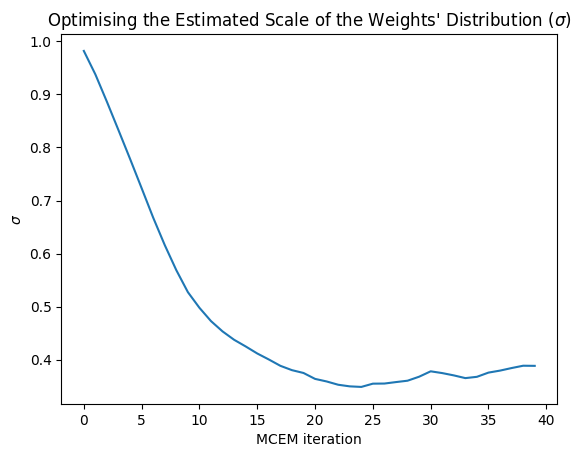

In [22]:
plt.plot(weights_prior_estimated_scale_)
plt.title('Optimising the Estimated Scale of the Weights\' Distribution ($\\sigma$)')
plt.ylabel('$\\sigma$')
plt.xlabel('MCEM iteration') # NOTE: MCEM = Monte Carlo Expectation Maximisation
plt.show()

# 5. HMC for sampling a high-dimensional parameter
> **Reference**: [`tfp.mcmc.sample_chain` (Tensorflow documentation)](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/sample_chain)

---

So far, we have only seen posterior distributions of single weights. Now, we shall see how to sample from the posterior distribution of a high-dimensional parameter, i.e. a parameter with multiple weights. This is relevant for applying HMC to a neural network's weights, which is my ultimate goal in learning about HMC.

## Necessary imports

In [6]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
tfd = tfp.distributions

## Running the sampler

In [3]:
# Some arrays for later inspection (not relevant to the sampling):
thetas, log_likelihoods, max_storage = [], [], 50

# Defining the target probability function:
dims = 10
true_stddev = tf.sqrt(tf.linspace(1., 3., dims))
likelihood = tfd.MultivariateNormalDiag(loc=0., scale_diag=true_stddev)
def target_prob_fn(theta):
    # Storing values to be inspected later:
    if max_storage < 50: # To limit the storage of values to be inspected later
        thetas.append(theta)
        log_likelihoods.append(likelihood.log_prob(theta))
        max_storage += 1

    # Returning the likelihood:
    return likelihood.log_prob(theta)

'''
NOTE: For the above, passing `likelihood` to `target_log_prob_fn` below is sufficient.
But because I wanted to store values to inspect later, I wrap it in the above function.
'''

# Running the sample chain:
states = tfp.mcmc.sample_chain(
    num_results=500,
    num_burnin_steps=250,
    current_state=tf.zeros(dims),
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_prob_fn,
        step_size=0.5,
        num_leapfrog_steps=2),
    trace_fn=None)

## Presenting the obtained samples

Obtaining and presenting sample mean and standard deviation...

In [31]:
sample_mean = tf.reduce_mean(states, axis=0) # Approximately all zeros
sample_stddev = tf.sqrt(tf.reduce_mean(tf.math.squared_difference(states, sample_mean), axis=0)) # Approximately = `true_stddev`

print('sample mean:', sample_mean)
print('\nsample stddev:', sample_mean)

sample mean: tf.Tensor(
[-0.09911468 -0.08771215  0.27116138 -0.02249406  0.08820967  0.12641178
  0.00938834  0.11089953 -0.22857717 -0.05526808], shape=(10,), dtype=float32)

sample stddev: tf.Tensor(
[-0.09911468 -0.08771215  0.27116138 -0.02249406  0.08820967  0.12641178
  0.00938834  0.11089953 -0.22857717 -0.05526808], shape=(10,), dtype=float32)


Checking sampled states...

In [29]:
print('Shape of the array of sampled states obtained:', states.shape)

# Inspecting a random theta and log-likelihood obtained during sampling:
pick = np.random.choice(max_storage)
print('\ntheta:', thetas[pick])
print('\nlog-likelihood:', log_likelihoods[pick])

Shape of the array of sampled states obtained: (500, 10)

theta: tf.Tensor(
[-0.2208701   1.2989653  -0.67676055 -0.9347783  -0.3518006  -1.9374292
 -1.7002003   0.2895801  -1.7173626   0.9078449 ], shape=(10,), dtype=float32)

log-likelihood: tf.Tensor(-15.734713, shape=(), dtype=float32)
